In [8]:
from utils import write_loss, get_config, Timer
from trainer import MUNIT_Trainer, UNIT_Trainer
import torch.backends.cudnn as cudnn
import torch
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import json
import numpy as np
from fid_score import calculate_frechet_distance

from my_utils import (multiple_gpu_gen, multiple_gpu_dis,
                      load_dataset, LoaderSampler, tensor2img,
                      get_Z_pushed_loader_stats, make_prediction)

In [2]:
opts_trainer = "MUNIT"
opts_output_path = "."
opts_resume = False

opts_config = "configs/handbags2shoes.yaml"
config = get_config(opts_config)
max_iter = config['max_iter']
display_size = config['display_size']
config['vgg_model_path'] = opts_output_path
batch_size = config['batch_size']

DEVICE_IDS = [3, 4]
SEED = 0x000000

device = f'cuda:{DEVICE_IDS[0]}'

In [3]:
trainer = MUNIT_Trainer(config, device)

iteration = "00630001"
gen_a_name = "gen_a_" + iteration + ".pt"
gen_a_name_full = os.path.join("models/handbags2shoes", gen_a_name)

gen_b_name = "gen_b_" + iteration + ".pt"
gen_b_name_full = os.path.join("models/handbags2shoes", gen_b_name)

state_dict_a = torch.load(gen_a_name_full)
state_dict_b = torch.load(gen_b_name_full)

trainer.gen_a.load_state_dict(state_dict_a['a'])
trainer.gen_b.load_state_dict(state_dict_b['b'])

trainer = trainer.to(device)

In [4]:
DATASET1, DATASET1_PATH = 'handbag', '../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../data/shoes_128.hdf5'

IMG_SIZE = 64

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

Keys: KeysView(<HDF5 file "handbag_128.hdf5" (mode r)>)


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Keys: KeysView(<HDF5 file "shoes_128.hdf5" (mode r)>)


In [5]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

In [11]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

num_calculation_fid = 10

fid_values = []

for i in range(num_calculation_fid):

    mu, sigma = get_Z_pushed_loader_stats(trainer, X_test_sampler.loader, device)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
    
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FID = 15.764635798475751
FID = 15.969812855029488
FID = 15.594956370443072
FID = 15.875486861795281
FID = 15.753015411134044
FID = 15.86366673529642
FID = 15.660707275633825
FID = 15.746038692602326
FID = 15.66652931387921
FID = 15.676114281421235
--------
Mean FID = 15.757096359571065
Std FID = 0.11007195421209494


In [10]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_test_fixed_variable = Variable(X_test_fixed).to(device)

num_examples = 4
Y_test_fakes = []

for v in range(num_examples):
    prior_z_B_current = Variable(torch.randn(X_test_fixed_variable.size(0), trainer.style_dim, 1, 1)).to(device)

    fake_Y_test = make_prediction(X_test_fixed_variable, prior_z_B_current, trainer).detach()
    fake_Y_test_numpy = tensor2img(fake_Y_test)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

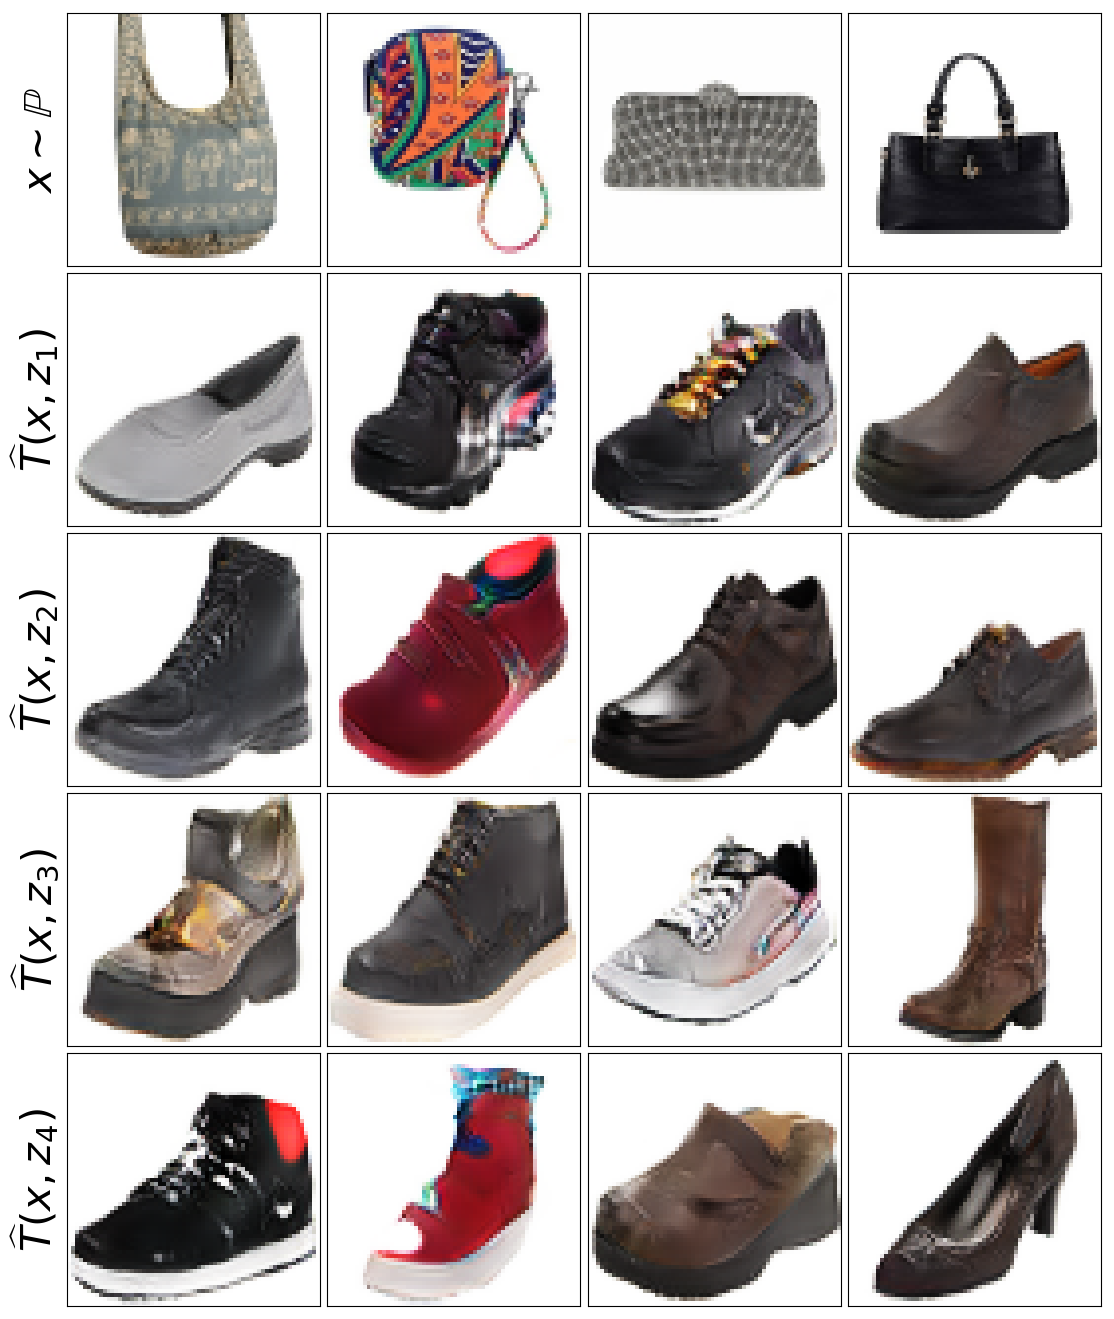

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("munit_bags2shoes_test.png")